In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1079604, 1040)
(1079604, 3)
validation
(190293, 1040)
(190293, 3)
test
(137379, 1040)
(137379, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1755395 (6.70 MB)


Trainable params: 1755395 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:12 - loss: 1.3720 - STD: 0.2585 - MAE: 0.4417

  4/108 [>.............................] - ETA: 1s - loss: 1.1992 - STD: 0.1292 - MAE: 0.4429  

  7/108 [>.............................] - ETA: 1s - loss: 1.1812 - STD: 0.1189 - MAE: 0.4429

 10/108 [=>............................] - ETA: 1s - loss: 1.1556 - STD: 0.0928 - MAE: 0.4428

 13/108 [==>...........................] - ETA: 1s - loss: 1.1448 - STD: 0.0898 - MAE: 0.4424

 16/108 [===>..........................] - ETA: 1s - loss: 1.1328 - STD: 0.0822 - MAE: 0.4416

 19/108 [====>.........................] - ETA: 1s - loss: 1.1200 - STD: 0.0744 - MAE: 0.4402

 22/108 [=====>........................] - ETA: 1s - loss: 1.1059 - STD: 0.0734 - MAE: 0.4375

 25/108 [=====>........................] - ETA: 1s - loss: 1.0866 - STD: 0.0756 - MAE: 0.4332

 28/108 [======>.......................] - ETA: 1s - loss: 1.0616 - STD: 0.0822 - MAE: 0.4268

 31/108 [=======>......................] - ETA: 1s - loss: 1.0340 - STD: 0.0925 - MAE: 0.4187

 34/108 [========>.....................] - ETA: 1s - loss: 1.0062 - STD: 0.1051 - MAE: 0.4095

 37/108 [=========>....................] - ETA: 1s - loss: 0.9805 - STD: 0.1182 - MAE: 0.4002

 40/108 [==========>...................] - ETA: 1s - loss: 0.9587 - STD: 0.1305 - MAE: 0.3916

 43/108 [==========>...................] - ETA: 1s - loss: 0.9385 - STD: 0.1414 - MAE: 0.3837

 46/108 [===========>..................] - ETA: 1s - loss: 0.9198 - STD: 0.1514 - MAE: 0.3763

 49/108 [============>.................] - ETA: 1s - loss: 0.9019 - STD: 0.1597 - MAE: 0.3698

 52/108 [=============>................] - ETA: 1s - loss: 0.8856 - STD: 0.1668 - MAE: 0.3640

 55/108 [==============>...............] - ETA: 1s - loss: 0.8707 - STD: 0.1734 - MAE: 0.3585

 58/108 [===============>..............] - ETA: 1s - loss: 0.8560 - STD: 0.1796 - MAE: 0.3531

 61/108 [===============>..............] - ETA: 1s - loss: 0.8423 - STD: 0.1859 - MAE: 0.3477

 64/108 [================>.............] - ETA: 1s - loss: 0.8287 - STD: 0.1921 - MAE: 0.3423

 67/108 [=================>............] - ETA: 1s - loss: 0.8155 - STD: 0.1978 - MAE: 0.3371

 70/108 [==================>...........] - ETA: 1s - loss: 0.8027 - STD: 0.2032 - MAE: 0.3320

 73/108 [===================>..........] - ETA: 1s - loss: 0.7896 - STD: 0.2085 - MAE: 0.3268

 76/108 [====================>.........] - ETA: 0s - loss: 0.7761 - STD: 0.2138 - MAE: 0.3214

 79/108 [====================>.........] - ETA: 0s - loss: 0.7624 - STD: 0.2190 - MAE: 0.3159

 82/108 [=====================>........] - ETA: 0s - loss: 0.7486 - STD: 0.2242 - MAE: 0.3102

 85/108 [======================>.......] - ETA: 0s - loss: 0.7347 - STD: 0.2294 - MAE: 0.3045

 88/108 [=======================>......] - ETA: 0s - loss: 0.7210 - STD: 0.2347 - MAE: 0.2986

 91/108 [========================>.....] - ETA: 0s - loss: 0.7072 - STD: 0.2400 - MAE: 0.2927

 94/108 [=========================>....] - ETA: 0s - loss: 0.6939 - STD: 0.2452 - MAE: 0.2870

 97/108 [=========================>....] - ETA: 0s - loss: 0.6811 - STD: 0.2502 - MAE: 0.2814

100/108 [==========================>...] - ETA: 0s - loss: 0.6688 - STD: 0.2550 - MAE: 0.2760

103/108 [===========================>..] - ETA: 0s - loss: 0.6570 - STD: 0.2596 - MAE: 0.2709

106/108 [============================>.] - ETA: 0s - loss: 0.6459 - STD: 0.2640 - MAE: 0.2660

108/108 [==============================] - 5s 35ms/step - loss: 0.6387 - STD: 0.2669 - MAE: 0.2628 - val_loss: 0.2770 - val_STD: 0.4121 - val_MAE: 0.1036


Epoch 2/10000


  1/108 [..............................] - ETA: 5s - loss: 0.2502 - STD: 0.4166 - MAE: 0.0937

  4/108 [>.............................] - ETA: 2s - loss: 0.2438 - STD: 0.4189 - MAE: 0.0906

  7/108 [>.............................] - ETA: 2s - loss: 0.2457 - STD: 0.4198 - MAE: 0.0904

 10/108 [=>............................] - ETA: 2s - loss: 0.2450 - STD: 0.4200 - MAE: 0.0901

 13/108 [==>...........................] - ETA: 2s - loss: 0.2433 - STD: 0.4200 - MAE: 0.0898

 16/108 [===>..........................] - ETA: 1s - loss: 0.2417 - STD: 0.4199 - MAE: 0.0896

 19/108 [====>.........................] - ETA: 1s - loss: 0.2401 - STD: 0.4199 - MAE: 0.0893

 22/108 [=====>........................] - ETA: 1s - loss: 0.2383 - STD: 0.4199 - MAE: 0.0890

 25/108 [=====>........................] - ETA: 1s - loss: 0.2367 - STD: 0.4201 - MAE: 0.0885

 28/108 [======>.......................] - ETA: 1s - loss: 0.2357 - STD: 0.4203 - MAE: 0.0881

 31/108 [=======>......................] - ETA: 1s - loss: 0.2341 - STD: 0.4206 - MAE: 0.0876

 34/108 [========>.....................] - ETA: 1s - loss: 0.2327 - STD: 0.4210 - MAE: 0.0870

 37/108 [=========>....................] - ETA: 1s - loss: 0.2321 - STD: 0.4212 - MAE: 0.0867

 40/108 [==========>...................] - ETA: 1s - loss: 0.2312 - STD: 0.4214 - MAE: 0.0864

 43/108 [==========>...................] - ETA: 1s - loss: 0.2300 - STD: 0.4217 - MAE: 0.0859

 46/108 [===========>..................] - ETA: 1s - loss: 0.2288 - STD: 0.4220 - MAE: 0.0855

 49/108 [============>.................] - ETA: 1s - loss: 0.2273 - STD: 0.4223 - MAE: 0.0850

 52/108 [=============>................] - ETA: 1s - loss: 0.2261 - STD: 0.4226 - MAE: 0.0845

 55/108 [==============>...............] - ETA: 1s - loss: 0.2249 - STD: 0.4229 - MAE: 0.0841

 58/108 [===============>..............] - ETA: 1s - loss: 0.2239 - STD: 0.4231 - MAE: 0.0837

 61/108 [===============>..............] - ETA: 0s - loss: 0.2227 - STD: 0.4234 - MAE: 0.0832

 64/108 [================>.............] - ETA: 0s - loss: 0.2215 - STD: 0.4236 - MAE: 0.0828

 67/108 [=================>............] - ETA: 0s - loss: 0.2208 - STD: 0.4238 - MAE: 0.0825

 70/108 [==================>...........] - ETA: 0s - loss: 0.2199 - STD: 0.4240 - MAE: 0.0822

 73/108 [===================>..........] - ETA: 0s - loss: 0.2192 - STD: 0.4242 - MAE: 0.0819

 76/108 [====================>.........] - ETA: 0s - loss: 0.2187 - STD: 0.4244 - MAE: 0.0817

 79/108 [====================>.........] - ETA: 0s - loss: 0.2183 - STD: 0.4246 - MAE: 0.0814

 82/108 [=====================>........] - ETA: 0s - loss: 0.2181 - STD: 0.4248 - MAE: 0.0812

 85/108 [======================>.......] - ETA: 0s - loss: 0.2174 - STD: 0.4251 - MAE: 0.0809

 88/108 [=======================>......] - ETA: 0s - loss: 0.2169 - STD: 0.4253 - MAE: 0.0806

 91/108 [========================>.....] - ETA: 0s - loss: 0.2164 - STD: 0.4255 - MAE: 0.0803

 94/108 [=========================>....] - ETA: 0s - loss: 0.2160 - STD: 0.4257 - MAE: 0.0801

 97/108 [=========================>....] - ETA: 0s - loss: 0.2154 - STD: 0.4258 - MAE: 0.0799

100/108 [==========================>...] - ETA: 0s - loss: 0.2150 - STD: 0.4259 - MAE: 0.0797

103/108 [===========================>..] - ETA: 0s - loss: 0.2144 - STD: 0.4261 - MAE: 0.0795

106/108 [============================>.] - ETA: 0s - loss: 0.2138 - STD: 0.4262 - MAE: 0.0793

108/108 [==============================] - 3s 25ms/step - loss: 0.2133 - STD: 0.4262 - MAE: 0.0792 - val_loss: 0.2155 - val_STD: 0.4280 - val_MAE: 0.0780


Epoch 3/10000


  1/108 [..............................] - ETA: 5s - loss: 0.2088 - STD: 0.4283 - MAE: 0.0768

  4/108 [>.............................] - ETA: 2s - loss: 0.1919 - STD: 0.4305 - MAE: 0.0716

  7/108 [>.............................] - ETA: 2s - loss: 0.1909 - STD: 0.4306 - MAE: 0.0714

 10/108 [=>............................] - ETA: 2s - loss: 0.1876 - STD: 0.4309 - MAE: 0.0705

 13/108 [==>...........................] - ETA: 2s - loss: 0.1873 - STD: 0.4312 - MAE: 0.0703

 16/108 [===>..........................] - ETA: 1s - loss: 0.1871 - STD: 0.4316 - MAE: 0.0699

 19/108 [====>.........................] - ETA: 1s - loss: 0.1853 - STD: 0.4319 - MAE: 0.0693

 22/108 [=====>........................] - ETA: 1s - loss: 0.1843 - STD: 0.4322 - MAE: 0.0689

 25/108 [=====>........................] - ETA: 1s - loss: 0.1847 - STD: 0.4324 - MAE: 0.0688

 28/108 [======>.......................] - ETA: 1s - loss: 0.1841 - STD: 0.4325 - MAE: 0.0686

 31/108 [=======>......................] - ETA: 1s - loss: 0.1836 - STD: 0.4327 - MAE: 0.0684

 34/108 [========>.....................] - ETA: 1s - loss: 0.1829 - STD: 0.4328 - MAE: 0.0682

 37/108 [=========>....................] - ETA: 1s - loss: 0.1823 - STD: 0.4330 - MAE: 0.0679

 40/108 [==========>...................] - ETA: 1s - loss: 0.1821 - STD: 0.4331 - MAE: 0.0677

 43/108 [==========>...................] - ETA: 1s - loss: 0.1816 - STD: 0.4332 - MAE: 0.0675

 46/108 [===========>..................] - ETA: 1s - loss: 0.1817 - STD: 0.4333 - MAE: 0.0675

 49/108 [============>.................] - ETA: 1s - loss: 0.1817 - STD: 0.4334 - MAE: 0.0674

 52/108 [=============>................] - ETA: 1s - loss: 0.1814 - STD: 0.4335 - MAE: 0.0672

 55/108 [==============>...............] - ETA: 1s - loss: 0.1808 - STD: 0.4336 - MAE: 0.0670

 58/108 [===============>..............] - ETA: 1s - loss: 0.1806 - STD: 0.4337 - MAE: 0.0670

 61/108 [===============>..............] - ETA: 0s - loss: 0.1803 - STD: 0.4338 - MAE: 0.0668

 64/108 [================>.............] - ETA: 0s - loss: 0.1798 - STD: 0.4339 - MAE: 0.0666

 67/108 [=================>............] - ETA: 0s - loss: 0.1794 - STD: 0.4339 - MAE: 0.0665

 70/108 [==================>...........] - ETA: 0s - loss: 0.1794 - STD: 0.4340 - MAE: 0.0665

 73/108 [===================>..........] - ETA: 0s - loss: 0.1788 - STD: 0.4340 - MAE: 0.0663

 76/108 [====================>.........] - ETA: 0s - loss: 0.1787 - STD: 0.4341 - MAE: 0.0662

 79/108 [====================>.........] - ETA: 0s - loss: 0.1788 - STD: 0.4341 - MAE: 0.0662

 82/108 [=====================>........] - ETA: 0s - loss: 0.1787 - STD: 0.4342 - MAE: 0.0661

 85/108 [======================>.......] - ETA: 0s - loss: 0.1785 - STD: 0.4343 - MAE: 0.0660

 88/108 [=======================>......] - ETA: 0s - loss: 0.1782 - STD: 0.4344 - MAE: 0.0659

 91/108 [========================>.....] - ETA: 0s - loss: 0.1778 - STD: 0.4345 - MAE: 0.0657

 94/108 [=========================>....] - ETA: 0s - loss: 0.1775 - STD: 0.4346 - MAE: 0.0656

 97/108 [=========================>....] - ETA: 0s - loss: 0.1773 - STD: 0.4347 - MAE: 0.0655

100/108 [==========================>...] - ETA: 0s - loss: 0.1769 - STD: 0.4347 - MAE: 0.0654

103/108 [===========================>..] - ETA: 0s - loss: 0.1765 - STD: 0.4348 - MAE: 0.0652

106/108 [============================>.] - ETA: 0s - loss: 0.1762 - STD: 0.4349 - MAE: 0.0651

108/108 [==============================] - 3s 25ms/step - loss: 0.1759 - STD: 0.4349 - MAE: 0.0650 - val_loss: 0.2038 - val_STD: 0.4361 - val_MAE: 0.0685


Epoch 4/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1804 - STD: 0.4366 - MAE: 0.0650

  4/108 [>.............................] - ETA: 2s - loss: 0.1724 - STD: 0.4366 - MAE: 0.0631

  7/108 [>.............................] - ETA: 2s - loss: 0.1705 - STD: 0.4366 - MAE: 0.0627

 10/108 [=>............................] - ETA: 2s - loss: 0.1702 - STD: 0.4367 - MAE: 0.0626

 13/108 [==>...........................] - ETA: 2s - loss: 0.1704 - STD: 0.4370 - MAE: 0.0624

 16/108 [===>..........................] - ETA: 1s - loss: 0.1710 - STD: 0.4371 - MAE: 0.0624

 19/108 [====>.........................] - ETA: 1s - loss: 0.1716 - STD: 0.4373 - MAE: 0.0624

 22/108 [=====>........................] - ETA: 1s - loss: 0.1706 - STD: 0.4374 - MAE: 0.0620

 25/108 [=====>........................] - ETA: 1s - loss: 0.1700 - STD: 0.4375 - MAE: 0.0618

 28/108 [======>.......................] - ETA: 1s - loss: 0.1695 - STD: 0.4376 - MAE: 0.0616

 31/108 [=======>......................] - ETA: 1s - loss: 0.1693 - STD: 0.4377 - MAE: 0.0615

 34/108 [========>.....................] - ETA: 1s - loss: 0.1689 - STD: 0.4377 - MAE: 0.0615

 37/108 [=========>....................] - ETA: 1s - loss: 0.1688 - STD: 0.4376 - MAE: 0.0615

 40/108 [==========>...................] - ETA: 1s - loss: 0.1688 - STD: 0.4376 - MAE: 0.0615

 43/108 [==========>...................] - ETA: 1s - loss: 0.1687 - STD: 0.4375 - MAE: 0.0616

 45/108 [===========>..................] - ETA: 1s - loss: 0.1686 - STD: 0.4375 - MAE: 0.0616

 48/108 [============>.................] - ETA: 1s - loss: 0.1681 - STD: 0.4374 - MAE: 0.0616

 51/108 [=============>................] - ETA: 1s - loss: 0.1676 - STD: 0.4374 - MAE: 0.0614

 54/108 [==============>...............] - ETA: 1s - loss: 0.1673 - STD: 0.4374 - MAE: 0.0614

 57/108 [==============>...............] - ETA: 1s - loss: 0.1667 - STD: 0.4375 - MAE: 0.0612

 60/108 [===============>..............] - ETA: 1s - loss: 0.1662 - STD: 0.4375 - MAE: 0.0611

 63/108 [================>.............] - ETA: 0s - loss: 0.1658 - STD: 0.4376 - MAE: 0.0610

 66/108 [=================>............] - ETA: 0s - loss: 0.1655 - STD: 0.4376 - MAE: 0.0609

 69/108 [==================>...........] - ETA: 0s - loss: 0.1650 - STD: 0.4377 - MAE: 0.0607

 72/108 [===================>..........] - ETA: 0s - loss: 0.1649 - STD: 0.4378 - MAE: 0.0606

 75/108 [===================>..........] - ETA: 0s - loss: 0.1652 - STD: 0.4378 - MAE: 0.0607

 78/108 [====================>.........] - ETA: 0s - loss: 0.1650 - STD: 0.4379 - MAE: 0.0605

 81/108 [=====================>........] - ETA: 0s - loss: 0.1648 - STD: 0.4380 - MAE: 0.0605

 84/108 [======================>.......] - ETA: 0s - loss: 0.1645 - STD: 0.4380 - MAE: 0.0604

 87/108 [=======================>......] - ETA: 0s - loss: 0.1645 - STD: 0.4381 - MAE: 0.0603

 90/108 [========================>.....] - ETA: 0s - loss: 0.1643 - STD: 0.4381 - MAE: 0.0603

 93/108 [========================>.....] - ETA: 0s - loss: 0.1640 - STD: 0.4381 - MAE: 0.0602

 96/108 [=========================>....] - ETA: 0s - loss: 0.1639 - STD: 0.4382 - MAE: 0.0601

 99/108 [==========================>...] - ETA: 0s - loss: 0.1638 - STD: 0.4382 - MAE: 0.0601

102/108 [===========================>..] - ETA: 0s - loss: 0.1637 - STD: 0.4382 - MAE: 0.0601

105/108 [============================>.] - ETA: 0s - loss: 0.1635 - STD: 0.4382 - MAE: 0.0600

108/108 [==============================] - ETA: 0s - loss: 0.1633 - STD: 0.4382 - MAE: 0.0600

108/108 [==============================] - 3s 25ms/step - loss: 0.1633 - STD: 0.4382 - MAE: 0.0600 - val_loss: 0.2112 - val_STD: 0.4409 - val_MAE: 0.0641


Epoch 5/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1556 - STD: 0.4389 - MAE: 0.0579

  4/108 [>.............................] - ETA: 2s - loss: 0.1598 - STD: 0.4398 - MAE: 0.0580

  7/108 [>.............................] - ETA: 2s - loss: 0.1581 - STD: 0.4395 - MAE: 0.0579

 10/108 [=>............................] - ETA: 2s - loss: 0.1553 - STD: 0.4397 - MAE: 0.0572

 13/108 [==>...........................] - ETA: 1s - loss: 0.1549 - STD: 0.4398 - MAE: 0.0570

 16/108 [===>..........................] - ETA: 1s - loss: 0.1544 - STD: 0.4400 - MAE: 0.0568

 19/108 [====>.........................] - ETA: 1s - loss: 0.1550 - STD: 0.4401 - MAE: 0.0569

 22/108 [=====>........................] - ETA: 1s - loss: 0.1554 - STD: 0.4401 - MAE: 0.0569

 25/108 [=====>........................] - ETA: 1s - loss: 0.1554 - STD: 0.4401 - MAE: 0.0569

 28/108 [======>.......................] - ETA: 1s - loss: 0.1558 - STD: 0.4402 - MAE: 0.0569

 31/108 [=======>......................] - ETA: 1s - loss: 0.1557 - STD: 0.4402 - MAE: 0.0570

 34/108 [========>.....................] - ETA: 1s - loss: 0.1554 - STD: 0.4402 - MAE: 0.0569

 37/108 [=========>....................] - ETA: 1s - loss: 0.1550 - STD: 0.4402 - MAE: 0.0568

 40/108 [==========>...................] - ETA: 1s - loss: 0.1549 - STD: 0.4402 - MAE: 0.0567

 43/108 [==========>...................] - ETA: 1s - loss: 0.1553 - STD: 0.4401 - MAE: 0.0569

 46/108 [===========>..................] - ETA: 1s - loss: 0.1557 - STD: 0.4401 - MAE: 0.0571

 49/108 [============>.................] - ETA: 1s - loss: 0.1567 - STD: 0.4400 - MAE: 0.0573

 52/108 [=============>................] - ETA: 1s - loss: 0.1575 - STD: 0.4400 - MAE: 0.0575

 55/108 [==============>...............] - ETA: 1s - loss: 0.1576 - STD: 0.4400 - MAE: 0.0575

 58/108 [===============>..............] - ETA: 1s - loss: 0.1574 - STD: 0.4400 - MAE: 0.0574

 61/108 [===============>..............] - ETA: 1s - loss: 0.1575 - STD: 0.4400 - MAE: 0.0574

 64/108 [================>.............] - ETA: 0s - loss: 0.1574 - STD: 0.4400 - MAE: 0.0574

 67/108 [=================>............] - ETA: 0s - loss: 0.1572 - STD: 0.4400 - MAE: 0.0574

 70/108 [==================>...........] - ETA: 0s - loss: 0.1568 - STD: 0.4400 - MAE: 0.0573

 73/108 [===================>..........] - ETA: 0s - loss: 0.1568 - STD: 0.4400 - MAE: 0.0573

 76/108 [====================>.........] - ETA: 0s - loss: 0.1566 - STD: 0.4400 - MAE: 0.0573

 79/108 [====================>.........] - ETA: 0s - loss: 0.1562 - STD: 0.4401 - MAE: 0.0572

 82/108 [=====================>........] - ETA: 0s - loss: 0.1558 - STD: 0.4401 - MAE: 0.0571

 85/108 [======================>.......] - ETA: 0s - loss: 0.1555 - STD: 0.4401 - MAE: 0.0570

 88/108 [=======================>......] - ETA: 0s - loss: 0.1553 - STD: 0.4401 - MAE: 0.0569

 91/108 [========================>.....] - ETA: 0s - loss: 0.1551 - STD: 0.4402 - MAE: 0.0569

 94/108 [=========================>....] - ETA: 0s - loss: 0.1550 - STD: 0.4402 - MAE: 0.0568

 97/108 [=========================>....] - ETA: 0s - loss: 0.1548 - STD: 0.4402 - MAE: 0.0568

100/108 [==========================>...] - ETA: 0s - loss: 0.1546 - STD: 0.4402 - MAE: 0.0567

103/108 [===========================>..] - ETA: 0s - loss: 0.1543 - STD: 0.4402 - MAE: 0.0567

106/108 [============================>.] - ETA: 0s - loss: 0.1543 - STD: 0.4402 - MAE: 0.0567

108/108 [==============================] - 3s 25ms/step - loss: 0.1542 - STD: 0.4403 - MAE: 0.0566 - val_loss: 0.2059 - val_STD: 0.4402 - val_MAE: 0.0642


Epoch 6/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1690 - STD: 0.4358 - MAE: 0.0633

  4/108 [>.............................] - ETA: 2s - loss: 0.1541 - STD: 0.4401 - MAE: 0.0566

  7/108 [>.............................] - ETA: 2s - loss: 0.1526 - STD: 0.4406 - MAE: 0.0559

 10/108 [=>............................] - ETA: 2s - loss: 0.1512 - STD: 0.4407 - MAE: 0.0557

 13/108 [==>...........................] - ETA: 2s - loss: 0.1517 - STD: 0.4408 - MAE: 0.0558

 16/108 [===>..........................] - ETA: 1s - loss: 0.1511 - STD: 0.4409 - MAE: 0.0556

 19/108 [====>.........................] - ETA: 1s - loss: 0.1511 - STD: 0.4410 - MAE: 0.0555

 22/108 [=====>........................] - ETA: 1s - loss: 0.1519 - STD: 0.4411 - MAE: 0.0556

 25/108 [=====>........................] - ETA: 1s - loss: 0.1510 - STD: 0.4412 - MAE: 0.0553

 28/108 [======>.......................] - ETA: 1s - loss: 0.1513 - STD: 0.4412 - MAE: 0.0554

 31/108 [=======>......................] - ETA: 1s - loss: 0.1514 - STD: 0.4412 - MAE: 0.0554

 34/108 [========>.....................] - ETA: 1s - loss: 0.1520 - STD: 0.4412 - MAE: 0.0555

 37/108 [=========>....................] - ETA: 1s - loss: 0.1533 - STD: 0.4411 - MAE: 0.0558

 40/108 [==========>...................] - ETA: 1s - loss: 0.1534 - STD: 0.4411 - MAE: 0.0559

 43/108 [==========>...................] - ETA: 1s - loss: 0.1533 - STD: 0.4411 - MAE: 0.0558

 46/108 [===========>..................] - ETA: 1s - loss: 0.1528 - STD: 0.4412 - MAE: 0.0557

 49/108 [============>.................] - ETA: 1s - loss: 0.1523 - STD: 0.4412 - MAE: 0.0556

 52/108 [=============>................] - ETA: 1s - loss: 0.1523 - STD: 0.4412 - MAE: 0.0556

 55/108 [==============>...............] - ETA: 1s - loss: 0.1518 - STD: 0.4412 - MAE: 0.0555

 58/108 [===============>..............] - ETA: 1s - loss: 0.1513 - STD: 0.4412 - MAE: 0.0554

 61/108 [===============>..............] - ETA: 0s - loss: 0.1512 - STD: 0.4411 - MAE: 0.0554

 64/108 [================>.............] - ETA: 0s - loss: 0.1510 - STD: 0.4412 - MAE: 0.0554

 67/108 [=================>............] - ETA: 0s - loss: 0.1508 - STD: 0.4412 - MAE: 0.0553

 70/108 [==================>...........] - ETA: 0s - loss: 0.1507 - STD: 0.4412 - MAE: 0.0553

 73/108 [===================>..........] - ETA: 0s - loss: 0.1507 - STD: 0.4412 - MAE: 0.0553

 76/108 [====================>.........] - ETA: 0s - loss: 0.1505 - STD: 0.4412 - MAE: 0.0552

 79/108 [====================>.........] - ETA: 0s - loss: 0.1504 - STD: 0.4413 - MAE: 0.0551

 82/108 [=====================>........] - ETA: 0s - loss: 0.1502 - STD: 0.4413 - MAE: 0.0551

 85/108 [======================>.......] - ETA: 0s - loss: 0.1501 - STD: 0.4413 - MAE: 0.0551

 88/108 [=======================>......] - ETA: 0s - loss: 0.1499 - STD: 0.4413 - MAE: 0.0551

 91/108 [========================>.....] - ETA: 0s - loss: 0.1496 - STD: 0.4413 - MAE: 0.0550

 94/108 [=========================>....] - ETA: 0s - loss: 0.1495 - STD: 0.4413 - MAE: 0.0549

 97/108 [=========================>....] - ETA: 0s - loss: 0.1493 - STD: 0.4414 - MAE: 0.0549

100/108 [==========================>...] - ETA: 0s - loss: 0.1495 - STD: 0.4414 - MAE: 0.0549

103/108 [===========================>..] - ETA: 0s - loss: 0.1494 - STD: 0.4414 - MAE: 0.0548

106/108 [============================>.] - ETA: 0s - loss: 0.1494 - STD: 0.4415 - MAE: 0.0548

108/108 [==============================] - 3s 25ms/step - loss: 0.1493 - STD: 0.4414 - MAE: 0.0548 - val_loss: 0.2404 - val_STD: 0.4447 - val_MAE: 0.0647


Epoch 7/10000


  1/108 [..............................] - ETA: 7s - loss: 0.1665 - STD: 0.4440 - MAE: 0.0555

  4/108 [>.............................] - ETA: 2s - loss: 0.1525 - STD: 0.4426 - MAE: 0.0546

  7/108 [>.............................] - ETA: 2s - loss: 0.1519 - STD: 0.4423 - MAE: 0.0547

 10/108 [=>............................] - ETA: 2s - loss: 0.1526 - STD: 0.4419 - MAE: 0.0552

 13/108 [==>...........................] - ETA: 2s - loss: 0.1518 - STD: 0.4418 - MAE: 0.0552

 16/108 [===>..........................] - ETA: 1s - loss: 0.1505 - STD: 0.4418 - MAE: 0.0549

 19/108 [====>.........................] - ETA: 1s - loss: 0.1494 - STD: 0.4419 - MAE: 0.0546

 22/108 [=====>........................] - ETA: 1s - loss: 0.1488 - STD: 0.4419 - MAE: 0.0544

 25/108 [=====>........................] - ETA: 1s - loss: 0.1485 - STD: 0.4420 - MAE: 0.0543

 28/108 [======>.......................] - ETA: 1s - loss: 0.1480 - STD: 0.4420 - MAE: 0.0542

 31/108 [=======>......................] - ETA: 1s - loss: 0.1471 - STD: 0.4420 - MAE: 0.0540

 34/108 [========>.....................] - ETA: 1s - loss: 0.1468 - STD: 0.4419 - MAE: 0.0540

 37/108 [=========>....................] - ETA: 1s - loss: 0.1467 - STD: 0.4419 - MAE: 0.0540

 40/108 [==========>...................] - ETA: 1s - loss: 0.1459 - STD: 0.4419 - MAE: 0.0538

 43/108 [==========>...................] - ETA: 1s - loss: 0.1455 - STD: 0.4419 - MAE: 0.0538

 46/108 [===========>..................] - ETA: 1s - loss: 0.1448 - STD: 0.4420 - MAE: 0.0536

 49/108 [============>.................] - ETA: 1s - loss: 0.1450 - STD: 0.4420 - MAE: 0.0536

 52/108 [=============>................] - ETA: 1s - loss: 0.1449 - STD: 0.4420 - MAE: 0.0536

 55/108 [==============>...............] - ETA: 1s - loss: 0.1453 - STD: 0.4420 - MAE: 0.0536

 58/108 [===============>..............] - ETA: 1s - loss: 0.1454 - STD: 0.4421 - MAE: 0.0536

 61/108 [===============>..............] - ETA: 0s - loss: 0.1449 - STD: 0.4421 - MAE: 0.0535

 64/108 [================>.............] - ETA: 0s - loss: 0.1448 - STD: 0.4422 - MAE: 0.0534

 67/108 [=================>............] - ETA: 0s - loss: 0.1445 - STD: 0.4422 - MAE: 0.0533

 70/108 [==================>...........] - ETA: 0s - loss: 0.1443 - STD: 0.4422 - MAE: 0.0533

 73/108 [===================>..........] - ETA: 0s - loss: 0.1441 - STD: 0.4422 - MAE: 0.0532

 76/108 [====================>.........] - ETA: 0s - loss: 0.1439 - STD: 0.4423 - MAE: 0.0532

 79/108 [====================>.........] - ETA: 0s - loss: 0.1438 - STD: 0.4423 - MAE: 0.0531

 82/108 [=====================>........] - ETA: 0s - loss: 0.1438 - STD: 0.4423 - MAE: 0.0531

 85/108 [======================>.......] - ETA: 0s - loss: 0.1442 - STD: 0.4422 - MAE: 0.0532

 88/108 [=======================>......] - ETA: 0s - loss: 0.1446 - STD: 0.4422 - MAE: 0.0534

 91/108 [========================>.....] - ETA: 0s - loss: 0.1454 - STD: 0.4422 - MAE: 0.0535

 94/108 [=========================>....] - ETA: 0s - loss: 0.1462 - STD: 0.4422 - MAE: 0.0537

 97/108 [=========================>....] - ETA: 0s - loss: 0.1465 - STD: 0.4423 - MAE: 0.0536

100/108 [==========================>...] - ETA: 0s - loss: 0.1469 - STD: 0.4423 - MAE: 0.0537

103/108 [===========================>..] - ETA: 0s - loss: 0.1472 - STD: 0.4423 - MAE: 0.0538

106/108 [============================>.] - ETA: 0s - loss: 0.1475 - STD: 0.4423 - MAE: 0.0538

108/108 [==============================] - 3s 25ms/step - loss: 0.1475 - STD: 0.4423 - MAE: 0.0538 - val_loss: 0.2029 - val_STD: 0.4429 - val_MAE: 0.0611


Epoch 8/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1368 - STD: 0.4411 - MAE: 0.0524

  4/108 [>.............................] - ETA: 2s - loss: 0.1421 - STD: 0.4412 - MAE: 0.0536

  7/108 [>.............................] - ETA: 2s - loss: 0.1435 - STD: 0.4408 - MAE: 0.0542

 10/108 [=>............................] - ETA: 2s - loss: 0.1433 - STD: 0.4408 - MAE: 0.0542

 13/108 [==>...........................] - ETA: 2s - loss: 0.1412 - STD: 0.4412 - MAE: 0.0536

 16/108 [===>..........................] - ETA: 1s - loss: 0.1412 - STD: 0.4415 - MAE: 0.0533

 19/108 [====>.........................] - ETA: 1s - loss: 0.1414 - STD: 0.4416 - MAE: 0.0533

 22/108 [=====>........................] - ETA: 1s - loss: 0.1408 - STD: 0.4417 - MAE: 0.0530

 25/108 [=====>........................] - ETA: 1s - loss: 0.1403 - STD: 0.4418 - MAE: 0.0528

 28/108 [======>.......................] - ETA: 1s - loss: 0.1397 - STD: 0.4419 - MAE: 0.0527

 31/108 [=======>......................] - ETA: 1s - loss: 0.1396 - STD: 0.4420 - MAE: 0.0526

 34/108 [========>.....................] - ETA: 1s - loss: 0.1398 - STD: 0.4421 - MAE: 0.0525

 37/108 [=========>....................] - ETA: 1s - loss: 0.1401 - STD: 0.4421 - MAE: 0.0525

 40/108 [==========>...................] - ETA: 1s - loss: 0.1399 - STD: 0.4422 - MAE: 0.0525

 43/108 [==========>...................] - ETA: 1s - loss: 0.1399 - STD: 0.4422 - MAE: 0.0524

 46/108 [===========>..................] - ETA: 1s - loss: 0.1402 - STD: 0.4423 - MAE: 0.0524

 49/108 [============>.................] - ETA: 1s - loss: 0.1404 - STD: 0.4423 - MAE: 0.0525

 52/108 [=============>................] - ETA: 1s - loss: 0.1405 - STD: 0.4423 - MAE: 0.0525

 55/108 [==============>...............] - ETA: 1s - loss: 0.1405 - STD: 0.4424 - MAE: 0.0525

 58/108 [===============>..............] - ETA: 1s - loss: 0.1406 - STD: 0.4424 - MAE: 0.0524

 61/108 [===============>..............] - ETA: 0s - loss: 0.1407 - STD: 0.4425 - MAE: 0.0524

 64/108 [================>.............] - ETA: 0s - loss: 0.1410 - STD: 0.4425 - MAE: 0.0525

 67/108 [=================>............] - ETA: 0s - loss: 0.1410 - STD: 0.4425 - MAE: 0.0524

 70/108 [==================>...........] - ETA: 0s - loss: 0.1411 - STD: 0.4425 - MAE: 0.0525

 73/108 [===================>..........] - ETA: 0s - loss: 0.1410 - STD: 0.4425 - MAE: 0.0524

 76/108 [====================>.........] - ETA: 0s - loss: 0.1410 - STD: 0.4425 - MAE: 0.0524

 79/108 [====================>.........] - ETA: 0s - loss: 0.1409 - STD: 0.4425 - MAE: 0.0524

 82/108 [=====================>........] - ETA: 0s - loss: 0.1408 - STD: 0.4425 - MAE: 0.0524

 85/108 [======================>.......] - ETA: 0s - loss: 0.1408 - STD: 0.4426 - MAE: 0.0523

 88/108 [=======================>......] - ETA: 0s - loss: 0.1405 - STD: 0.4426 - MAE: 0.0523

 91/108 [========================>.....] - ETA: 0s - loss: 0.1404 - STD: 0.4426 - MAE: 0.0522

 94/108 [=========================>....] - ETA: 0s - loss: 0.1402 - STD: 0.4427 - MAE: 0.0521

 97/108 [=========================>....] - ETA: 0s - loss: 0.1401 - STD: 0.4427 - MAE: 0.0521

100/108 [==========================>...] - ETA: 0s - loss: 0.1401 - STD: 0.4428 - MAE: 0.0520

103/108 [===========================>..] - ETA: 0s - loss: 0.1400 - STD: 0.4428 - MAE: 0.0520

106/108 [============================>.] - ETA: 0s - loss: 0.1400 - STD: 0.4428 - MAE: 0.0520

108/108 [==============================] - 3s 25ms/step - loss: 0.1401 - STD: 0.4428 - MAE: 0.0520 - val_loss: 0.1904 - val_STD: 0.4432 - val_MAE: 0.0594


Epoch 9/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1382 - STD: 0.4417 - MAE: 0.0529

  4/108 [>.............................] - ETA: 2s - loss: 0.1398 - STD: 0.4429 - MAE: 0.0519

  7/108 [>.............................] - ETA: 2s - loss: 0.1389 - STD: 0.4431 - MAE: 0.0517

 10/108 [=>............................] - ETA: 2s - loss: 0.1382 - STD: 0.4433 - MAE: 0.0513

 13/108 [==>...........................] - ETA: 2s - loss: 0.1371 - STD: 0.4435 - MAE: 0.0509

 16/108 [===>..........................] - ETA: 1s - loss: 0.1367 - STD: 0.4436 - MAE: 0.0507

 19/108 [====>.........................] - ETA: 1s - loss: 0.1367 - STD: 0.4436 - MAE: 0.0507

 22/108 [=====>........................] - ETA: 1s - loss: 0.1373 - STD: 0.4435 - MAE: 0.0509

 25/108 [=====>........................] - ETA: 1s - loss: 0.1368 - STD: 0.4435 - MAE: 0.0507

 28/108 [======>.......................] - ETA: 1s - loss: 0.1379 - STD: 0.4435 - MAE: 0.0510

 31/108 [=======>......................] - ETA: 1s - loss: 0.1383 - STD: 0.4435 - MAE: 0.0511

 34/108 [========>.....................] - ETA: 1s - loss: 0.1383 - STD: 0.4435 - MAE: 0.0510

 37/108 [=========>....................] - ETA: 1s - loss: 0.1380 - STD: 0.4436 - MAE: 0.0509

 40/108 [==========>...................] - ETA: 1s - loss: 0.1378 - STD: 0.4437 - MAE: 0.0508

 43/108 [==========>...................] - ETA: 1s - loss: 0.1379 - STD: 0.4437 - MAE: 0.0508

 46/108 [===========>..................] - ETA: 1s - loss: 0.1381 - STD: 0.4437 - MAE: 0.0509

 49/108 [============>.................] - ETA: 1s - loss: 0.1381 - STD: 0.4436 - MAE: 0.0509

 52/108 [=============>................] - ETA: 1s - loss: 0.1379 - STD: 0.4437 - MAE: 0.0509

 55/108 [==============>...............] - ETA: 1s - loss: 0.1379 - STD: 0.4437 - MAE: 0.0508

 58/108 [===============>..............] - ETA: 1s - loss: 0.1376 - STD: 0.4437 - MAE: 0.0508

 61/108 [===============>..............] - ETA: 0s - loss: 0.1376 - STD: 0.4437 - MAE: 0.0508

 64/108 [================>.............] - ETA: 0s - loss: 0.1374 - STD: 0.4437 - MAE: 0.0507

 67/108 [=================>............] - ETA: 0s - loss: 0.1372 - STD: 0.4437 - MAE: 0.0507

 70/108 [==================>...........] - ETA: 0s - loss: 0.1370 - STD: 0.4437 - MAE: 0.0507

 73/108 [===================>..........] - ETA: 0s - loss: 0.1369 - STD: 0.4437 - MAE: 0.0506

 76/108 [====================>.........] - ETA: 0s - loss: 0.1369 - STD: 0.4437 - MAE: 0.0506

 79/108 [====================>.........] - ETA: 0s - loss: 0.1364 - STD: 0.4438 - MAE: 0.0505

 82/108 [=====================>........] - ETA: 0s - loss: 0.1362 - STD: 0.4438 - MAE: 0.0504

 85/108 [======================>.......] - ETA: 0s - loss: 0.1360 - STD: 0.4438 - MAE: 0.0504

 88/108 [=======================>......] - ETA: 0s - loss: 0.1360 - STD: 0.4438 - MAE: 0.0504

 91/108 [========================>.....] - ETA: 0s - loss: 0.1361 - STD: 0.4439 - MAE: 0.0503

 94/108 [=========================>....] - ETA: 0s - loss: 0.1363 - STD: 0.4439 - MAE: 0.0503

 97/108 [=========================>....] - ETA: 0s - loss: 0.1365 - STD: 0.4440 - MAE: 0.0504

100/108 [==========================>...] - ETA: 0s - loss: 0.1370 - STD: 0.4439 - MAE: 0.0505

103/108 [===========================>..] - ETA: 0s - loss: 0.1369 - STD: 0.4439 - MAE: 0.0505

106/108 [============================>.] - ETA: 0s - loss: 0.1369 - STD: 0.4439 - MAE: 0.0505

108/108 [==============================] - 3s 25ms/step - loss: 0.1371 - STD: 0.4439 - MAE: 0.0505 - val_loss: 0.1968 - val_STD: 0.4454 - val_MAE: 0.0574


Epoch 10/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1284 - STD: 0.4457 - MAE: 0.0472

  4/108 [>.............................] - ETA: 2s - loss: 0.1369 - STD: 0.4438 - MAE: 0.0507

  7/108 [>.............................] - ETA: 2s - loss: 0.1376 - STD: 0.4433 - MAE: 0.0512

 10/108 [=>............................] - ETA: 2s - loss: 0.1374 - STD: 0.4434 - MAE: 0.0511

 13/108 [==>...........................] - ETA: 2s - loss: 0.1364 - STD: 0.4435 - MAE: 0.0508

 16/108 [===>..........................] - ETA: 1s - loss: 0.1351 - STD: 0.4436 - MAE: 0.0504

 19/108 [====>.........................] - ETA: 1s - loss: 0.1345 - STD: 0.4437 - MAE: 0.0502

 22/108 [=====>........................] - ETA: 1s - loss: 0.1354 - STD: 0.4437 - MAE: 0.0504

 25/108 [=====>........................] - ETA: 1s - loss: 0.1361 - STD: 0.4436 - MAE: 0.0507

 28/108 [======>.......................] - ETA: 1s - loss: 0.1370 - STD: 0.4435 - MAE: 0.0509

 31/108 [=======>......................] - ETA: 1s - loss: 0.1380 - STD: 0.4435 - MAE: 0.0510

 34/108 [========>.....................] - ETA: 1s - loss: 0.1397 - STD: 0.4435 - MAE: 0.0514

 37/108 [=========>....................] - ETA: 1s - loss: 0.1405 - STD: 0.4436 - MAE: 0.0515

 40/108 [==========>...................] - ETA: 1s - loss: 0.1411 - STD: 0.4435 - MAE: 0.0517

 43/108 [==========>...................] - ETA: 1s - loss: 0.1410 - STD: 0.4436 - MAE: 0.0516

 46/108 [===========>..................] - ETA: 1s - loss: 0.1406 - STD: 0.4436 - MAE: 0.0515

 49/108 [============>.................] - ETA: 1s - loss: 0.1402 - STD: 0.4436 - MAE: 0.0514

 52/108 [=============>................] - ETA: 1s - loss: 0.1402 - STD: 0.4436 - MAE: 0.0514

 55/108 [==============>...............] - ETA: 1s - loss: 0.1399 - STD: 0.4437 - MAE: 0.0513

 58/108 [===============>..............] - ETA: 1s - loss: 0.1398 - STD: 0.4437 - MAE: 0.0513

 61/108 [===============>..............] - ETA: 0s - loss: 0.1395 - STD: 0.4437 - MAE: 0.0513

 64/108 [================>.............] - ETA: 0s - loss: 0.1391 - STD: 0.4437 - MAE: 0.0512

 67/108 [=================>............] - ETA: 0s - loss: 0.1388 - STD: 0.4437 - MAE: 0.0511

 70/108 [==================>...........] - ETA: 0s - loss: 0.1383 - STD: 0.4437 - MAE: 0.0510

 73/108 [===================>..........] - ETA: 0s - loss: 0.1379 - STD: 0.4437 - MAE: 0.0509

 76/108 [====================>.........] - ETA: 0s - loss: 0.1374 - STD: 0.4437 - MAE: 0.0508

 79/108 [====================>.........] - ETA: 0s - loss: 0.1372 - STD: 0.4438 - MAE: 0.0507

 82/108 [=====================>........] - ETA: 0s - loss: 0.1369 - STD: 0.4438 - MAE: 0.0506

 85/108 [======================>.......] - ETA: 0s - loss: 0.1365 - STD: 0.4438 - MAE: 0.0505

 88/108 [=======================>......] - ETA: 0s - loss: 0.1362 - STD: 0.4439 - MAE: 0.0504

 91/108 [========================>.....] - ETA: 0s - loss: 0.1359 - STD: 0.4439 - MAE: 0.0503

 94/108 [=========================>....] - ETA: 0s - loss: 0.1356 - STD: 0.4440 - MAE: 0.0503

 97/108 [=========================>....] - ETA: 0s - loss: 0.1355 - STD: 0.4440 - MAE: 0.0502

100/108 [==========================>...] - ETA: 0s - loss: 0.1354 - STD: 0.4441 - MAE: 0.0501

103/108 [===========================>..] - ETA: 0s - loss: 0.1354 - STD: 0.4441 - MAE: 0.0501

106/108 [============================>.] - ETA: 0s - loss: 0.1354 - STD: 0.4441 - MAE: 0.0501

108/108 [==============================] - 3s 25ms/step - loss: 0.1354 - STD: 0.4441 - MAE: 0.0501 - val_loss: 0.2193 - val_STD: 0.4464 - val_MAE: 0.0598


Epoch 11/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1333 - STD: 0.4474 - MAE: 0.0466

  4/108 [>.............................] - ETA: 2s - loss: 0.1328 - STD: 0.4458 - MAE: 0.0481

  7/108 [>.............................] - ETA: 2s - loss: 0.1330 - STD: 0.4452 - MAE: 0.0487

 10/108 [=>............................] - ETA: 2s - loss: 0.1336 - STD: 0.4451 - MAE: 0.0489

 13/108 [==>...........................] - ETA: 2s - loss: 0.1335 - STD: 0.4450 - MAE: 0.0490

 16/108 [===>..........................] - ETA: 1s - loss: 0.1338 - STD: 0.4449 - MAE: 0.0492

 19/108 [====>.........................] - ETA: 1s - loss: 0.1334 - STD: 0.4448 - MAE: 0.0491

 22/108 [=====>........................] - ETA: 1s - loss: 0.1336 - STD: 0.4448 - MAE: 0.0491

 25/108 [=====>........................] - ETA: 1s - loss: 0.1339 - STD: 0.4447 - MAE: 0.0493

 28/108 [======>.......................] - ETA: 1s - loss: 0.1341 - STD: 0.4448 - MAE: 0.0493

 31/108 [=======>......................] - ETA: 1s - loss: 0.1337 - STD: 0.4448 - MAE: 0.0492

 34/108 [========>.....................] - ETA: 1s - loss: 0.1335 - STD: 0.4449 - MAE: 0.0490

 37/108 [=========>....................] - ETA: 1s - loss: 0.1334 - STD: 0.4450 - MAE: 0.0490

 40/108 [==========>...................] - ETA: 1s - loss: 0.1333 - STD: 0.4449 - MAE: 0.0490

 43/108 [==========>...................] - ETA: 1s - loss: 0.1334 - STD: 0.4449 - MAE: 0.0491

 46/108 [===========>..................] - ETA: 1s - loss: 0.1336 - STD: 0.4448 - MAE: 0.0492

 49/108 [============>.................] - ETA: 1s - loss: 0.1338 - STD: 0.4448 - MAE: 0.0493

 52/108 [=============>................] - ETA: 1s - loss: 0.1342 - STD: 0.4448 - MAE: 0.0493

 55/108 [==============>...............] - ETA: 1s - loss: 0.1343 - STD: 0.4448 - MAE: 0.0494

 58/108 [===============>..............] - ETA: 1s - loss: 0.1344 - STD: 0.4448 - MAE: 0.0494

 61/108 [===============>..............] - ETA: 0s - loss: 0.1344 - STD: 0.4447 - MAE: 0.0494

 64/108 [================>.............] - ETA: 0s - loss: 0.1341 - STD: 0.4448 - MAE: 0.0493

 67/108 [=================>............] - ETA: 0s - loss: 0.1337 - STD: 0.4448 - MAE: 0.0492

 70/108 [==================>...........] - ETA: 0s - loss: 0.1336 - STD: 0.4448 - MAE: 0.0492

 73/108 [===================>..........] - ETA: 0s - loss: 0.1337 - STD: 0.4448 - MAE: 0.0492

 76/108 [====================>.........] - ETA: 0s - loss: 0.1336 - STD: 0.4448 - MAE: 0.0492

 79/108 [====================>.........] - ETA: 0s - loss: 0.1335 - STD: 0.4448 - MAE: 0.0492

 82/108 [=====================>........] - ETA: 0s - loss: 0.1336 - STD: 0.4448 - MAE: 0.0492

 85/108 [======================>.......] - ETA: 0s - loss: 0.1337 - STD: 0.4448 - MAE: 0.0492

 88/108 [=======================>......] - ETA: 0s - loss: 0.1338 - STD: 0.4448 - MAE: 0.0492

 91/108 [========================>.....] - ETA: 0s - loss: 0.1340 - STD: 0.4448 - MAE: 0.0493

 94/108 [=========================>....] - ETA: 0s - loss: 0.1341 - STD: 0.4448 - MAE: 0.0493

 97/108 [=========================>....] - ETA: 0s - loss: 0.1339 - STD: 0.4448 - MAE: 0.0493

100/108 [==========================>...] - ETA: 0s - loss: 0.1335 - STD: 0.4448 - MAE: 0.0492

103/108 [===========================>..] - ETA: 0s - loss: 0.1333 - STD: 0.4447 - MAE: 0.0492

106/108 [============================>.] - ETA: 0s - loss: 0.1333 - STD: 0.4447 - MAE: 0.0492

108/108 [==============================] - 3s 25ms/step - loss: 0.1332 - STD: 0.4447 - MAE: 0.0492 - val_loss: 0.2010 - val_STD: 0.4460 - val_MAE: 0.0575


Epoch 12/10000


  1/108 [..............................] - ETA: 6s - loss: 0.1359 - STD: 0.4460 - MAE: 0.0484

  4/108 [>.............................] - ETA: 2s - loss: 0.1301 - STD: 0.4454 - MAE: 0.0480

  7/108 [>.............................] - ETA: 2s - loss: 0.1298 - STD: 0.4452 - MAE: 0.0482

 10/108 [=>............................] - ETA: 2s - loss: 0.1299 - STD: 0.4452 - MAE: 0.0481

 13/108 [==>...........................] - ETA: 2s - loss: 0.1300 - STD: 0.4452 - MAE: 0.0482

 16/108 [===>..........................] - ETA: 1s - loss: 0.1302 - STD: 0.4451 - MAE: 0.0483

 19/108 [====>.........................] - ETA: 1s - loss: 0.1314 - STD: 0.4451 - MAE: 0.0486

 22/108 [=====>........................] - ETA: 1s - loss: 0.1323 - STD: 0.4451 - MAE: 0.0487

 25/108 [=====>........................] - ETA: 1s - loss: 0.1324 - STD: 0.4452 - MAE: 0.0487

 28/108 [======>.......................] - ETA: 1s - loss: 0.1330 - STD: 0.4452 - MAE: 0.0488

 31/108 [=======>......................] - ETA: 1s - loss: 0.1325 - STD: 0.4452 - MAE: 0.0486

 34/108 [========>.....................] - ETA: 1s - loss: 0.1329 - STD: 0.4452 - MAE: 0.0488

 37/108 [=========>....................] - ETA: 1s - loss: 0.1331 - STD: 0.4451 - MAE: 0.0488

 40/108 [==========>...................] - ETA: 1s - loss: 0.1331 - STD: 0.4451 - MAE: 0.0489

 43/108 [==========>...................] - ETA: 1s - loss: 0.1326 - STD: 0.4451 - MAE: 0.0488

 46/108 [===========>..................] - ETA: 1s - loss: 0.1321 - STD: 0.4451 - MAE: 0.0487

 49/108 [============>.................] - ETA: 1s - loss: 0.1317 - STD: 0.4451 - MAE: 0.0486

 52/108 [=============>................] - ETA: 1s - loss: 0.1314 - STD: 0.4451 - MAE: 0.0485

 55/108 [==============>...............] - ETA: 1s - loss: 0.1314 - STD: 0.4452 - MAE: 0.0485

 58/108 [===============>..............] - ETA: 1s - loss: 0.1316 - STD: 0.4452 - MAE: 0.0485

 61/108 [===============>..............] - ETA: 0s - loss: 0.1315 - STD: 0.4452 - MAE: 0.0485

 64/108 [================>.............] - ETA: 0s - loss: 0.1313 - STD: 0.4452 - MAE: 0.0485

 67/108 [=================>............] - ETA: 0s - loss: 0.1312 - STD: 0.4451 - MAE: 0.0485

 70/108 [==================>...........] - ETA: 0s - loss: 0.1311 - STD: 0.4451 - MAE: 0.0485

 73/108 [===================>..........] - ETA: 0s - loss: 0.1310 - STD: 0.4451 - MAE: 0.0484

 76/108 [====================>.........] - ETA: 0s - loss: 0.1309 - STD: 0.4451 - MAE: 0.0484

 79/108 [====================>.........] - ETA: 0s - loss: 0.1310 - STD: 0.4451 - MAE: 0.0484

 82/108 [=====================>........] - ETA: 0s - loss: 0.1310 - STD: 0.4452 - MAE: 0.0484

 85/108 [======================>.......] - ETA: 0s - loss: 0.1309 - STD: 0.4452 - MAE: 0.0484

 88/108 [=======================>......] - ETA: 0s - loss: 0.1310 - STD: 0.4452 - MAE: 0.0484

 91/108 [========================>.....] - ETA: 0s - loss: 0.1313 - STD: 0.4452 - MAE: 0.0484

 94/108 [=========================>....] - ETA: 0s - loss: 0.1313 - STD: 0.4452 - MAE: 0.0484

 97/108 [=========================>....] - ETA: 0s - loss: 0.1313 - STD: 0.4452 - MAE: 0.0484

100/108 [==========================>...] - ETA: 0s - loss: 0.1313 - STD: 0.4452 - MAE: 0.0484

103/108 [===========================>..] - ETA: 0s - loss: 0.1311 - STD: 0.4452 - MAE: 0.0483

106/108 [============================>.] - ETA: 0s - loss: 0.1310 - STD: 0.4452 - MAE: 0.0483

108/108 [==============================] - 3s 25ms/step - loss: 0.1309 - STD: 0.4452 - MAE: 0.0483 - val_loss: 0.1923 - val_STD: 0.4455 - val_MAE: 0.0574


Epoch 13/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1219 - STD: 0.4449 - MAE: 0.0466

  4/108 [>.............................] - ETA: 2s - loss: 0.1214 - STD: 0.4455 - MAE: 0.0460

  7/108 [>.............................] - ETA: 2s - loss: 0.1228 - STD: 0.4455 - MAE: 0.0464

 10/108 [=>............................] - ETA: 2s - loss: 0.1226 - STD: 0.4457 - MAE: 0.0463

 13/108 [==>...........................] - ETA: 2s - loss: 0.1221 - STD: 0.4459 - MAE: 0.0461

 16/108 [===>..........................] - ETA: 1s - loss: 0.1226 - STD: 0.4459 - MAE: 0.0462

 19/108 [====>.........................] - ETA: 1s - loss: 0.1229 - STD: 0.4459 - MAE: 0.0462

 22/108 [=====>........................] - ETA: 1s - loss: 0.1235 - STD: 0.4459 - MAE: 0.0464

 25/108 [=====>........................] - ETA: 1s - loss: 0.1246 - STD: 0.4458 - MAE: 0.0467

 28/108 [======>.......................] - ETA: 1s - loss: 0.1244 - STD: 0.4458 - MAE: 0.0466

 31/108 [=======>......................] - ETA: 1s - loss: 0.1241 - STD: 0.4459 - MAE: 0.0465

 34/108 [========>.....................] - ETA: 1s - loss: 0.1242 - STD: 0.4459 - MAE: 0.0465

 37/108 [=========>....................] - ETA: 1s - loss: 0.1246 - STD: 0.4459 - MAE: 0.0466

 40/108 [==========>...................] - ETA: 1s - loss: 0.1259 - STD: 0.4458 - MAE: 0.0469

 43/108 [==========>...................] - ETA: 1s - loss: 0.1266 - STD: 0.4459 - MAE: 0.0470

 46/108 [===========>..................] - ETA: 1s - loss: 0.1278 - STD: 0.4458 - MAE: 0.0472

 49/108 [============>.................] - ETA: 1s - loss: 0.1300 - STD: 0.4457 - MAE: 0.0477

 52/108 [=============>................] - ETA: 1s - loss: 0.1352 - STD: 0.4456 - MAE: 0.0488

 55/108 [==============>...............] - ETA: 1s - loss: 0.1406 - STD: 0.4454 - MAE: 0.0499

 58/108 [===============>..............] - ETA: 1s - loss: 0.1424 - STD: 0.4454 - MAE: 0.0503

 61/108 [===============>..............] - ETA: 0s - loss: 0.1446 - STD: 0.4453 - MAE: 0.0508

 64/108 [================>.............] - ETA: 0s - loss: 0.1454 - STD: 0.4451 - MAE: 0.0511

 67/108 [=================>............] - ETA: 0s - loss: 0.1460 - STD: 0.4448 - MAE: 0.0515

 70/108 [==================>...........] - ETA: 0s - loss: 0.1462 - STD: 0.4446 - MAE: 0.0517

 73/108 [===================>..........] - ETA: 0s - loss: 0.1458 - STD: 0.4443 - MAE: 0.0519

 76/108 [====================>.........] - ETA: 0s - loss: 0.1459 - STD: 0.4441 - MAE: 0.0521

 79/108 [====================>.........] - ETA: 0s - loss: 0.1459 - STD: 0.4439 - MAE: 0.0522

 82/108 [=====================>........] - ETA: 0s - loss: 0.1455 - STD: 0.4438 - MAE: 0.0522

 85/108 [======================>.......] - ETA: 0s - loss: 0.1451 - STD: 0.4438 - MAE: 0.0522

 88/108 [=======================>......] - ETA: 0s - loss: 0.1447 - STD: 0.4437 - MAE: 0.0522

 91/108 [========================>.....] - ETA: 0s - loss: 0.1442 - STD: 0.4437 - MAE: 0.0521

 94/108 [=========================>....] - ETA: 0s - loss: 0.1435 - STD: 0.4437 - MAE: 0.0520

 97/108 [=========================>....] - ETA: 0s - loss: 0.1429 - STD: 0.4437 - MAE: 0.0518

100/108 [==========================>...] - ETA: 0s - loss: 0.1424 - STD: 0.4437 - MAE: 0.0517

103/108 [===========================>..] - ETA: 0s - loss: 0.1420 - STD: 0.4437 - MAE: 0.0517

106/108 [============================>.] - ETA: 0s - loss: 0.1415 - STD: 0.4438 - MAE: 0.0515

108/108 [==============================] - 3s 25ms/step - loss: 0.1412 - STD: 0.4438 - MAE: 0.0515 - val_loss: 0.1966 - val_STD: 0.4457 - val_MAE: 0.0571


Epoch 14/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1231 - STD: 0.4456 - MAE: 0.0465

  4/108 [>.............................] - ETA: 2s - loss: 0.1215 - STD: 0.4456 - MAE: 0.0462

  7/108 [>.............................] - ETA: 2s - loss: 0.1233 - STD: 0.4454 - MAE: 0.0467

 10/108 [=>............................] - ETA: 2s - loss: 0.1233 - STD: 0.4455 - MAE: 0.0466

 13/108 [==>...........................] - ETA: 2s - loss: 0.1236 - STD: 0.4456 - MAE: 0.0465

 16/108 [===>..........................] - ETA: 1s - loss: 0.1242 - STD: 0.4455 - MAE: 0.0468

 19/108 [====>.........................] - ETA: 1s - loss: 0.1264 - STD: 0.4453 - MAE: 0.0474

 22/108 [=====>........................] - ETA: 1s - loss: 0.1280 - STD: 0.4453 - MAE: 0.0477

 25/108 [=====>........................] - ETA: 1s - loss: 0.1283 - STD: 0.4455 - MAE: 0.0476

 28/108 [======>.......................] - ETA: 1s - loss: 0.1287 - STD: 0.4456 - MAE: 0.0476

 31/108 [=======>......................] - ETA: 1s - loss: 0.1283 - STD: 0.4457 - MAE: 0.0475

 34/108 [========>.....................] - ETA: 1s - loss: 0.1281 - STD: 0.4457 - MAE: 0.0474

 37/108 [=========>....................] - ETA: 1s - loss: 0.1284 - STD: 0.4457 - MAE: 0.0475

 40/108 [==========>...................] - ETA: 1s - loss: 0.1281 - STD: 0.4457 - MAE: 0.0474

 43/108 [==========>...................] - ETA: 1s - loss: 0.1280 - STD: 0.4457 - MAE: 0.0474

 46/108 [===========>..................] - ETA: 1s - loss: 0.1279 - STD: 0.4457 - MAE: 0.0474

 49/108 [============>.................] - ETA: 1s - loss: 0.1279 - STD: 0.4456 - MAE: 0.0475

 52/108 [=============>................] - ETA: 1s - loss: 0.1280 - STD: 0.4456 - MAE: 0.0475

 55/108 [==============>...............] - ETA: 1s - loss: 0.1278 - STD: 0.4456 - MAE: 0.0475

 58/108 [===============>..............] - ETA: 1s - loss: 0.1278 - STD: 0.4456 - MAE: 0.0475

 61/108 [===============>..............] - ETA: 0s - loss: 0.1277 - STD: 0.4456 - MAE: 0.0474

 64/108 [================>.............] - ETA: 0s - loss: 0.1277 - STD: 0.4456 - MAE: 0.0475

 67/108 [=================>............] - ETA: 0s - loss: 0.1274 - STD: 0.4456 - MAE: 0.0474

 70/108 [==================>...........] - ETA: 0s - loss: 0.1275 - STD: 0.4456 - MAE: 0.0474

 73/108 [===================>..........] - ETA: 0s - loss: 0.1273 - STD: 0.4456 - MAE: 0.0474

 76/108 [====================>.........] - ETA: 0s - loss: 0.1272 - STD: 0.4456 - MAE: 0.0474

 79/108 [====================>.........] - ETA: 0s - loss: 0.1269 - STD: 0.4456 - MAE: 0.0473

 82/108 [=====================>........] - ETA: 0s - loss: 0.1267 - STD: 0.4456 - MAE: 0.0473

 85/108 [======================>.......] - ETA: 0s - loss: 0.1267 - STD: 0.4456 - MAE: 0.0473

 88/108 [=======================>......] - ETA: 0s - loss: 0.1267 - STD: 0.4456 - MAE: 0.0472

 91/108 [========================>.....] - ETA: 0s - loss: 0.1265 - STD: 0.4456 - MAE: 0.0472

 94/108 [=========================>....] - ETA: 0s - loss: 0.1265 - STD: 0.4456 - MAE: 0.0472

 97/108 [=========================>....] - ETA: 0s - loss: 0.1266 - STD: 0.4457 - MAE: 0.0472

100/108 [==========================>...] - ETA: 0s - loss: 0.1266 - STD: 0.4457 - MAE: 0.0471

103/108 [===========================>..] - ETA: 0s - loss: 0.1267 - STD: 0.4458 - MAE: 0.0471

106/108 [============================>.] - ETA: 0s - loss: 0.1268 - STD: 0.4458 - MAE: 0.0471

108/108 [==============================] - 3s 24ms/step - loss: 0.1269 - STD: 0.4458 - MAE: 0.0471 - val_loss: 0.1940 - val_STD: 0.4469 - val_MAE: 0.0561


Epoch 15/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1198 - STD: 0.4464 - MAE: 0.0450

  4/108 [>.............................] - ETA: 2s - loss: 0.1245 - STD: 0.4461 - MAE: 0.0465

  7/108 [>.............................] - ETA: 2s - loss: 0.1260 - STD: 0.4461 - MAE: 0.0468

 10/108 [=>............................] - ETA: 2s - loss: 0.1258 - STD: 0.4459 - MAE: 0.0469

 13/108 [==>...........................] - ETA: 2s - loss: 0.1249 - STD: 0.4457 - MAE: 0.0468

 16/108 [===>..........................] - ETA: 1s - loss: 0.1243 - STD: 0.4458 - MAE: 0.0466

 19/108 [====>.........................] - ETA: 1s - loss: 0.1231 - STD: 0.4458 - MAE: 0.0464

 22/108 [=====>........................] - ETA: 1s - loss: 0.1226 - STD: 0.4458 - MAE: 0.0463

 25/108 [=====>........................] - ETA: 1s - loss: 0.1226 - STD: 0.4460 - MAE: 0.0462

 28/108 [======>.......................] - ETA: 1s - loss: 0.1222 - STD: 0.4461 - MAE: 0.0460

 31/108 [=======>......................] - ETA: 1s - loss: 0.1217 - STD: 0.4461 - MAE: 0.0459

 34/108 [========>.....................] - ETA: 1s - loss: 0.1222 - STD: 0.4461 - MAE: 0.0460

 37/108 [=========>....................] - ETA: 1s - loss: 0.1226 - STD: 0.4461 - MAE: 0.0461

 40/108 [==========>...................] - ETA: 1s - loss: 0.1230 - STD: 0.4462 - MAE: 0.0461

 43/108 [==========>...................] - ETA: 1s - loss: 0.1227 - STD: 0.4462 - MAE: 0.0460

 46/108 [===========>..................] - ETA: 1s - loss: 0.1226 - STD: 0.4462 - MAE: 0.0459

 49/108 [============>.................] - ETA: 1s - loss: 0.1229 - STD: 0.4463 - MAE: 0.0460

 52/108 [=============>................] - ETA: 1s - loss: 0.1232 - STD: 0.4463 - MAE: 0.0460

 55/108 [==============>...............] - ETA: 1s - loss: 0.1235 - STD: 0.4462 - MAE: 0.0461

 58/108 [===============>..............] - ETA: 1s - loss: 0.1246 - STD: 0.4461 - MAE: 0.0464

 61/108 [===============>..............] - ETA: 0s - loss: 0.1270 - STD: 0.4460 - MAE: 0.0470

 64/108 [================>.............] - ETA: 0s - loss: 0.1310 - STD: 0.4459 - MAE: 0.0478

 67/108 [=================>............] - ETA: 0s - loss: 0.1322 - STD: 0.4460 - MAE: 0.0480

 70/108 [==================>...........] - ETA: 0s - loss: 0.1338 - STD: 0.4459 - MAE: 0.0484

 73/108 [===================>..........] - ETA: 0s - loss: 0.1342 - STD: 0.4458 - MAE: 0.0485

 76/108 [====================>.........] - ETA: 0s - loss: 0.1343 - STD: 0.4458 - MAE: 0.0485

 79/108 [====================>.........] - ETA: 0s - loss: 0.1341 - STD: 0.4457 - MAE: 0.0486

 82/108 [=====================>........] - ETA: 0s - loss: 0.1340 - STD: 0.4456 - MAE: 0.0486

 85/108 [======================>.......] - ETA: 0s - loss: 0.1338 - STD: 0.4455 - MAE: 0.0487

 88/108 [=======================>......] - ETA: 0s - loss: 0.1335 - STD: 0.4454 - MAE: 0.0487

 91/108 [========================>.....] - ETA: 0s - loss: 0.1332 - STD: 0.4454 - MAE: 0.0486

 94/108 [=========================>....] - ETA: 0s - loss: 0.1328 - STD: 0.4453 - MAE: 0.0486

 97/108 [=========================>....] - ETA: 0s - loss: 0.1326 - STD: 0.4453 - MAE: 0.0486

100/108 [==========================>...] - ETA: 0s - loss: 0.1322 - STD: 0.4453 - MAE: 0.0485

103/108 [===========================>..] - ETA: 0s - loss: 0.1319 - STD: 0.4454 - MAE: 0.0484

106/108 [============================>.] - ETA: 0s - loss: 0.1317 - STD: 0.4454 - MAE: 0.0483

108/108 [==============================] - 3s 25ms/step - loss: 0.1317 - STD: 0.4454 - MAE: 0.0483 - val_loss: 0.1972 - val_STD: 0.4471 - val_MAE: 0.0566


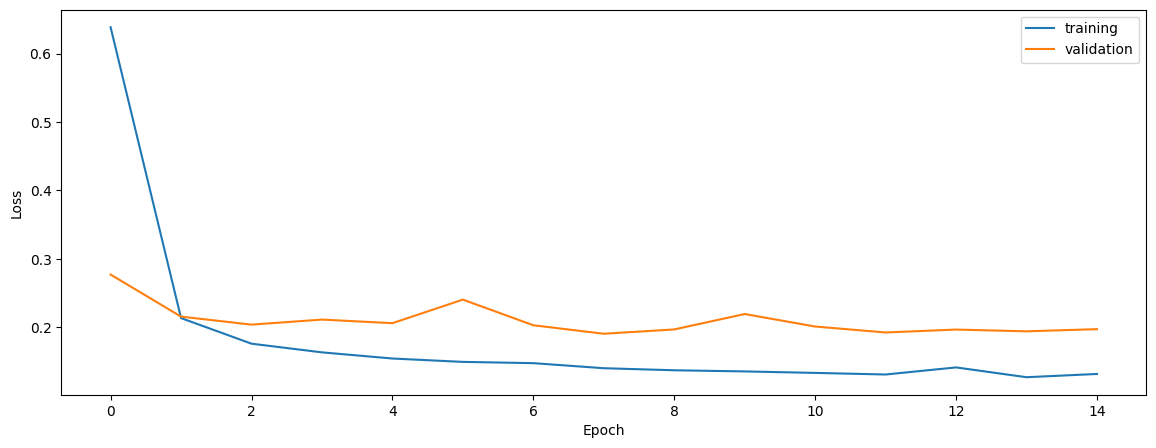

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

print('train')
print(getAccuracy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuracy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuracy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.947522424889126


0.9303442585906996


0.9327699284461235


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuracy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuracy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuracy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.9542339815977506


0.9321721328810347


0.9389958798203787


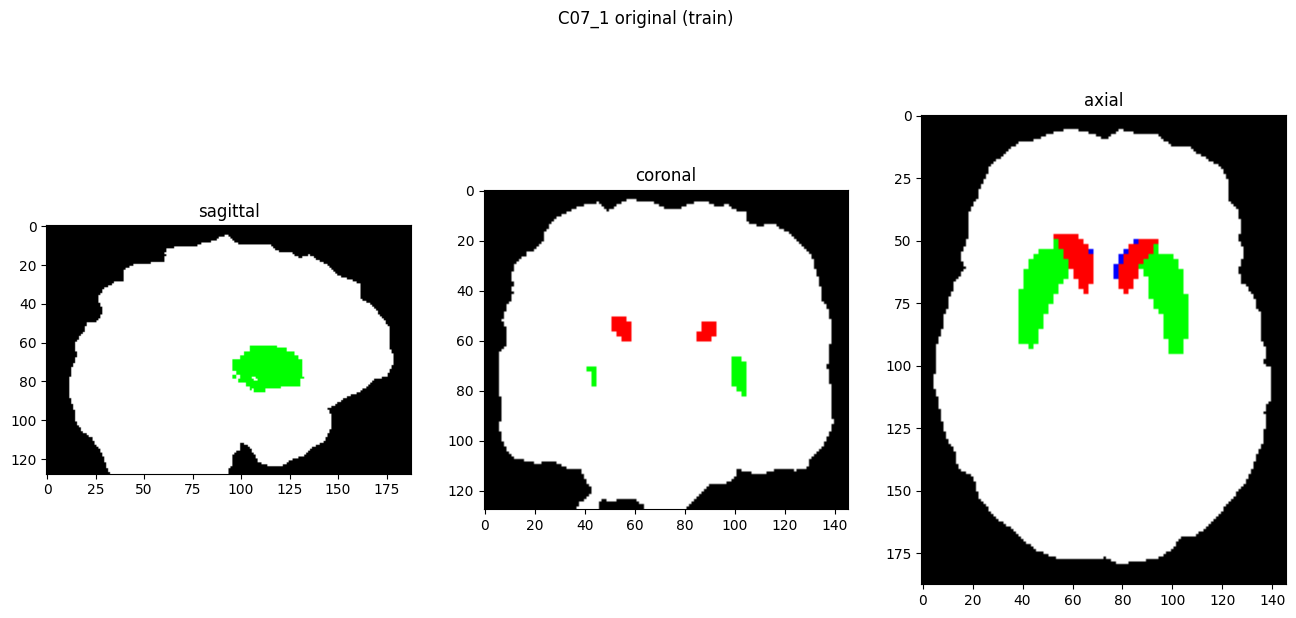

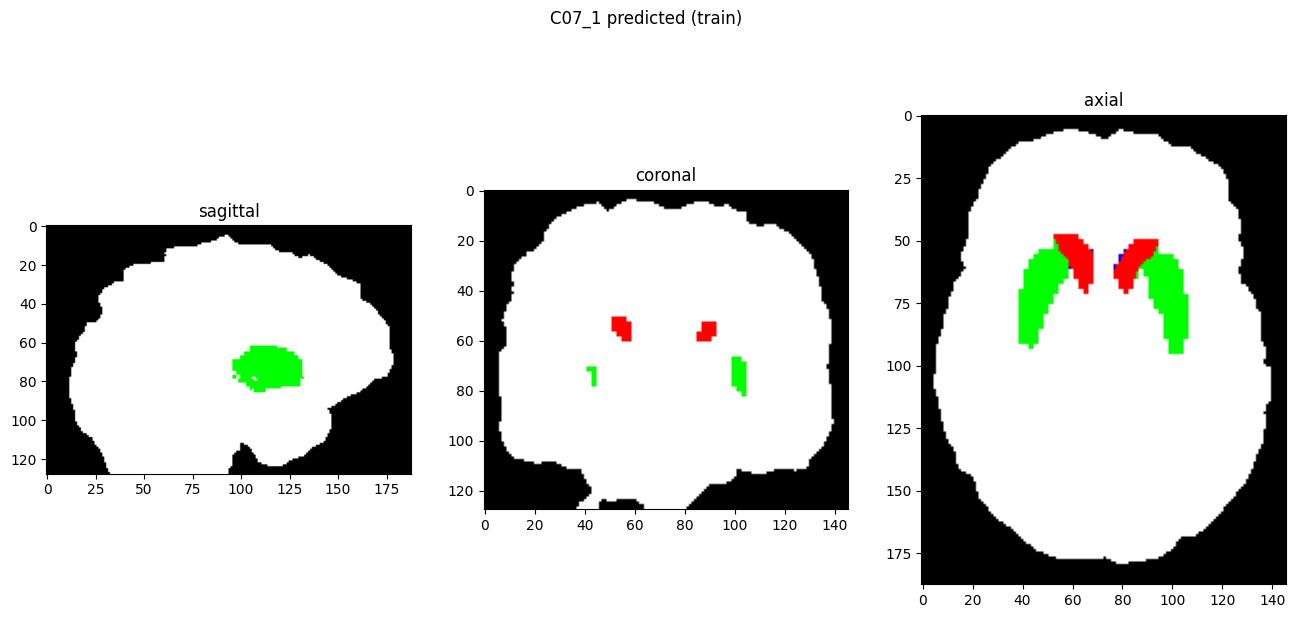

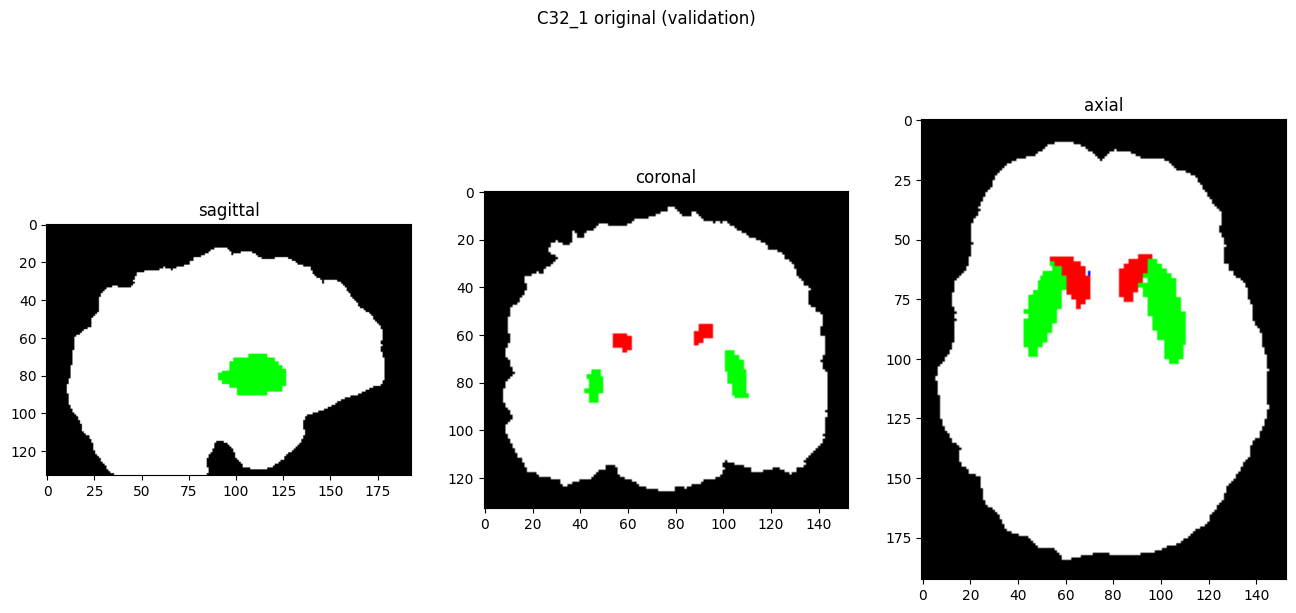

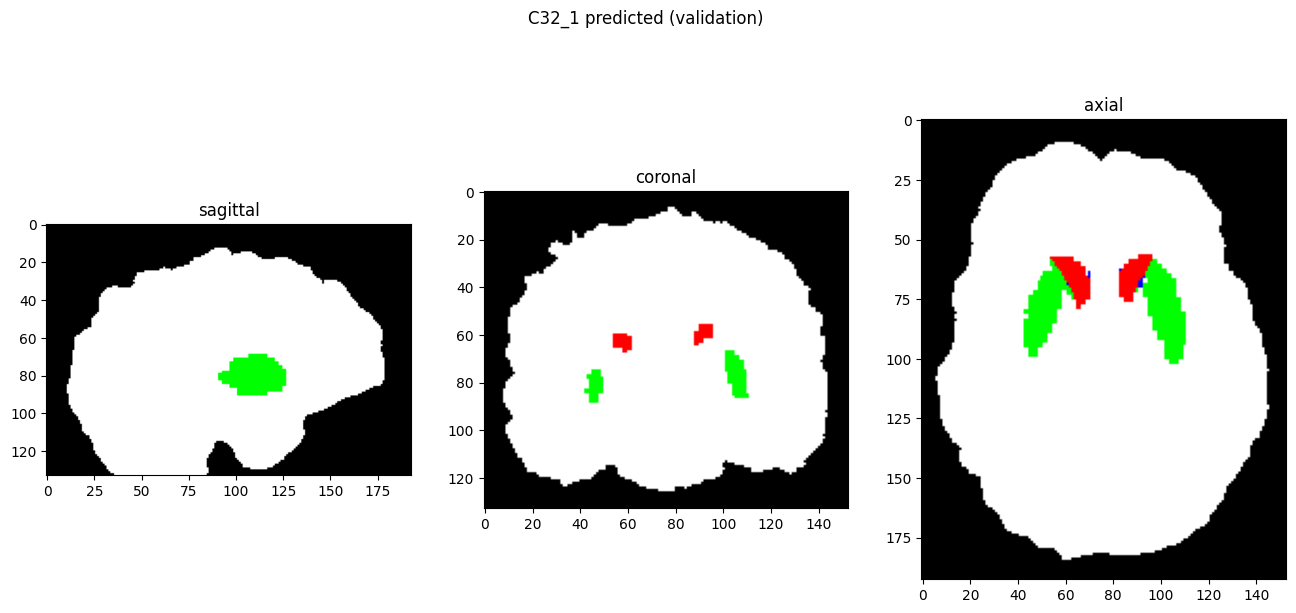

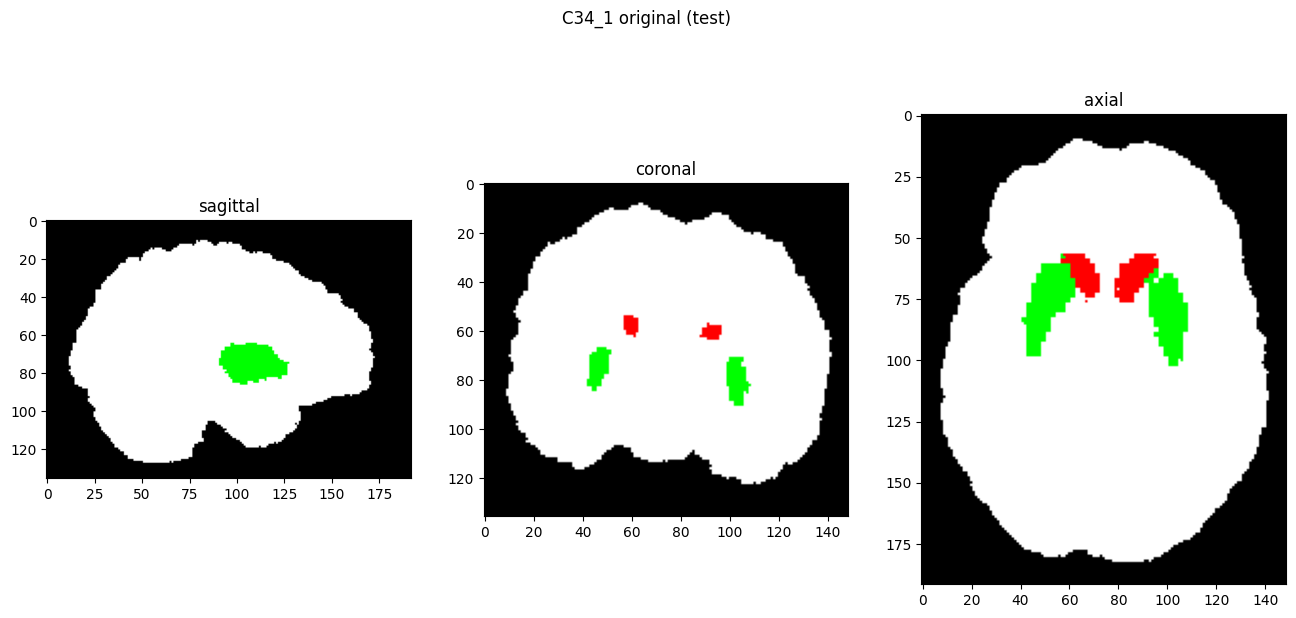

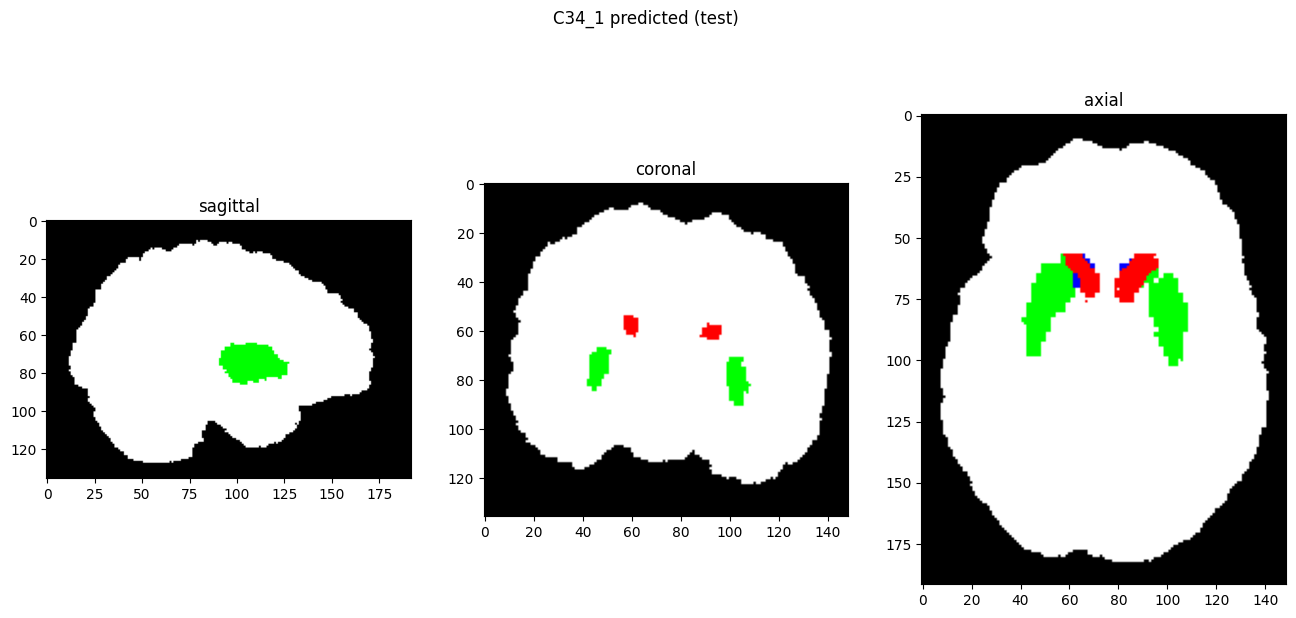

In [9]:
showResults(model, gen, threshold=0)